# Recommender Systems GPT

In [5]:
# Installation
!pip install openai -q
!pip install tiktoken -q

In [6]:
# Import the Needed Packages
import warnings
warnings.filterwarnings('ignore')

In [7]:
import pandas as pd
import numpy as np
import tiktoken
import openai
from pprint import pprint
import tiktoken
import os
from google.colab import userdata

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Load & inspect dataset
input_datapath = '/content/drive/MyDrive/Colab Notebooks/Recommender Systems/Reviews.csv'
df = pd.read_csv(input_datapath, index_col=0)

In [10]:
# Print top 5 records
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [11]:
# Access secret OpenAI key
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
openai.api_key = OPENAI_API_KEY

We will combine the review summary and review text into a single combined text. The model will encode this combined text and output a single vector embedding.

In [12]:
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)
df.head(2)

,Time,ProductId,UserId,Score,Summary,Text,combined
Id,,,,,,,
1,1303862400,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Title: Good Quality Dog Food; Content: I have ...
2,1346976000,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Title: Not as Advertised; Content: Product arr...


In [13]:
embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000  # the maximum for text-embedding-3-small is 8191

In [14]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def get_embedding(text, model="text-embedding-ada-002"): # model = "deployment_name"
    return client.embeddings.create(input = [text], model=model).data[0].embedding

In [15]:
# Subsample to 1k most recent reviews and remove samples that are too long
top_n = 1000
df = df.sort_values("Time").tail(top_n * 2)  # first cut to first 2k entries, assuming less than half will be filtered out
df.drop("Time", axis=1, inplace=True)

encoding = tiktoken.get_encoding(embedding_encoding)

# omit reviews that are too long to embed
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens].tail(top_n)

### Text search using embeddings

To retrieve the most relevant documents we use the cosine similarity between the embedding vectors of the query and each document, and return the highest scored documents.

In [16]:
from openai import OpenAI
client = OpenAI(
    api_key=OPENAI_API_KEY,
)

def search_reviews(df, product_description, n=3, pprint=True):
   embedding = get_embedding(product_description, model='text-embedding-3-small')
   df['similarities'] = df.embedding.apply(lambda x: cosine_similarity(x, embedding))
   res = df.sort_values('similarities', ascending=False).head(n)
   return res

In [17]:
# This may take a few minutes
df["embedding"] = df.combined.apply(lambda x: get_embedding(x, model=embedding_model))
df.to_csv("/content/drive/MyDrive/Colab Notebooks/Recommender Systems/fine_food_reviews_with_embeddings.csv")

In [18]:
# load embedding dataset
# output_datapath = '/content/drive/MyDrive/Colab Notebooks/Recommender Systems/fine_food_reviews_with_embeddings.csv'
# df = pd.read_csv(output_datapath)

In [19]:
def search_reviews(df, product_description, n=3, pprint=True):
    # Get the product embedding for the search query
    product_embedding = get_embedding(
        product_description,
        model="text-embedding-3-small"
    )

    # Sort and get the top results based on their embedding similarity
    results = (
        df.sort_values("embedding", ascending=False)
        .head(n)
        .copy()
    )

    if pprint:
        print("Top 3 Reviews Like & With Similar Content:")

        # Print the top results in the desired format
        for index, row in results.iterrows():
            print(f"ProductId: {row['ProductId']}")
            print(f"Summary: {row['Summary']}")
            print(f"Review: {row['Text'][:200]}")
            print(f"Score: {row['Score']}")
            print()

        # Find top reviews with similar content
        similar_reviews = df[df['Text'].str.contains(product_description, case=False)].head(n)

        # Print similar reviews if found
        for index, row in similar_reviews.iterrows():
            print(f"ProductId: {row['ProductId']}")
            print(f"Summary: {row['Summary']}")
            print(f"Review: {row['Text'][:200]}")
            print(f"Score: {row['Score']}")
            print()

    return results

In [21]:
# Result
results = search_reviews(df, "delicious beans", n=3)

Top 3 Reviews Like & With Similar Content:
ProductId: B0066DMI6Y
Summary: Great
Review: Great gift for all ages! I purchased these giant canes before and the recipients loved them so much, they kept them and would not eat them.
Score: 4

ProductId: B002BKTWL0
Summary: Great
Review: These smell so good and are cute and a great size, with a bend in the middle to help roll, and holds together really well with tasty glue. Definitely recommend. Smell like strawberry bubble gum, doesn
Score: 5

ProductId: B004X8TK8I
Summary: Wow
Review: I was not expecting to like these cookies as much as I do. I like chocolate chip cookies well enough, but I really prefer a soft cookie to crisp ones. I have to say these Famous Amos cookies have pert
Score: 5



In [28]:
# Result
results = search_reviews(df, "herbal tea", n=4)

Top 3 Reviews Like & With Similar Content:
ProductId: B001EU5S9S
Summary: Delicious!
Review: Love it, love it, love it!  Both me and my 10 year old drink this herbal tea quite often.  Very tasty!
Score: 5

ProductId: B0066DMI6Y
Summary: Great
Review: Great gift for all ages! I purchased these giant canes before and the recipients loved them so much, they kept them and would not eat them.
Score: 4

ProductId: B001EU5S9S
Summary: Delicious!
Review: Love it, love it, love it!  Both me and my 10 year old drink this herbal tea quite often.  Very tasty!
Score: 5

ProductId: B000LKZTSC
Summary: A Healing Tea
Review: A friend sent me two boxes of this for Christmas.  I thought it an odd gift, as I can just go out and buy herbal tea.  Shortly thereafter, I was flung into major stress and chaos during an extreme fam
Score: 5



### Visualizing the product score

In [23]:
# We reduce the dimensionality to 2 dimensions using t-SNE decomposition.

import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
from ast import literal_eval

# Load the embeddings
datafile_path = "/content/drive/MyDrive/Colab Notebooks/Recommender Systems/fine_food_reviews_with_embeddings.csv"
df = pd.read_csv(datafile_path)

# Convert to a list of lists of floats
matrix = np.array(df.embedding.apply(literal_eval).to_list())

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(1000, 2)

Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

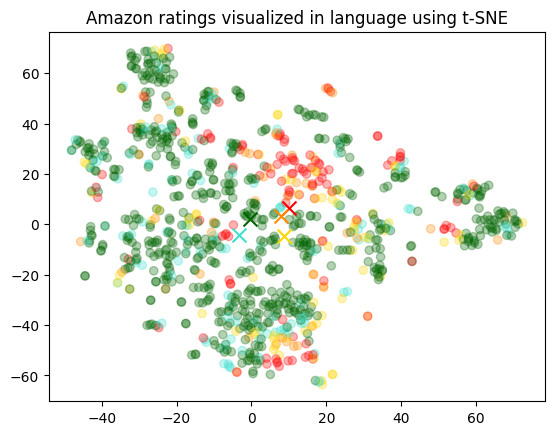

In [24]:
# We colour each review by its star rating, ranging from red to green.
# We can observe a decent data separation even in the reduced 2 dimensions.

import matplotlib.pyplot as plt
import matplotlib
import numpy as np

colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = df.Score.values - 1

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
for score in [0,1,2,3,4]:
    avg_x = np.array(x)[df.Score-1==score].mean()
    avg_y = np.array(y)[df.Score-1==score].mean()
    color = colors[score]
    plt.scatter(avg_x, avg_y, marker='x', color=color, s=100)

plt.title("Amazon ratings visualized in language using t-SNE")